In [12]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
from gpzoo.kernels import RBF, NSF_RBF
from gpzoo.gp import VNNGP, SVGP
from gpzoo.likelihoods import GaussianLikelihood, NSF

## VNNGP WITH GAUSSIAN LIKLIHOOD

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [14]:
N = 10000
X = distributions.Uniform(-5, 5).sample((N, ))
y = 2*torch.sin(2*X) + distributions.Normal(0.0, 0.1).sample((N,))

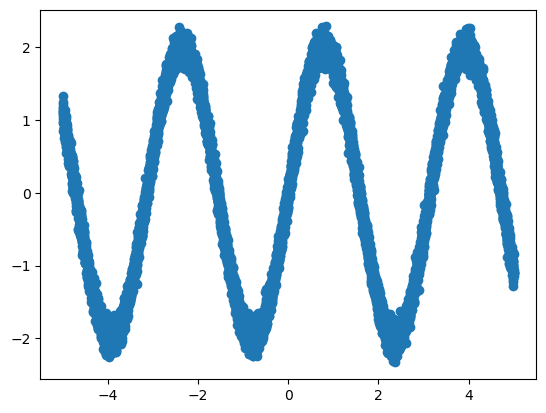

In [15]:
plt.scatter(X, y)

In [16]:
M = 1000
kernel = RBF(sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, dim=1, M=M, jitter=1e-3)
gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
model = GaussianLikelihood(gp)

In [17]:
model.to(device)

GaussianLikelihood(
  (gp): VNNGP(
    (kernel): RBF()
  )
)

In [18]:
X_train = (X[:, None]).to(device)
y_train = y.to(device)

In [19]:
print("X_train ", X_train.shape)
print("y_train ", y_train.shape)

X_train  torch.Size([10000, 1])
y_train  torch.Size([10000])


In [20]:
def fit(model, X, y, optimizer, epochs=1000, E=20):
    losses = []
    for it in tqdm(range(epochs)):
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X, E=E, verbose=True)
        ELBO = (pY.log_prob(y)).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        loss = -ELBO
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print("finished Training")
    return losses, gp.Z

In [21]:
model.gp.K = 5

In [22]:
optimizer = optim.Adam(params=model.parameters(), lr=1e-2)

In [23]:
losses = fit(model, X_train, y_train, optimizer, epochs=100, E=200)

  0%|          | 0/100 [00:00<?, ?it/s]

Kxx.shape before view  torch.Size([10000])
calculating Kxx
Kxx.shape torch.Size([10000, 1])
calculating Kxz
Kxz.shape torch.Size([10000, 1000])
calculating kzz
Kzz.shape torch.Size([1, 1000, 1000])
calculating little_Kzz
little_Kzz torch.Size([10000, 5, 5])
calculating L
L.shape torch.Size([1, 1000, 1000])
little_Kxz.shape: torch.Size([10000, 1, 5])
W_shape: torch.Size([10000, 1, 5])
mu before view  torch.Size([1000])
mu after view torch.Size([1, 1000])
torch.Size([10000, 1]) torch.Size([10000, 5, 5]) torch.Size([10000, 1, 5]) torch.Size([10000, 5]) torch.Size([10000, 5, 5])
Shapw W:  torch.Size([10000, 1, 5])
Shape inducing_mean  torch.Size([10000, 5])
Before squeeze
mean.shape: torch.Size([10000, 1, 1])
cov.shape: torch.Size([10000, 1])
After squeeze
mean.shape: torch.Size([10000])
cov.shape: torch.Size([10000, 1])


: 

: 

In [ ]:
plt.plot(losses)

In [ ]:
X_test = torch.linspace(-12, 12, 10000)

In [ ]:
qF, _, _ = model.gp(X_test[:, None].to(device), verbose=True)
mean_test = qF.mean.detach().cpu()

In [ ]:
plt.plot(X_test, mean_test, color='black')
plt.scatter(X, y, alpha=0.5)

In [ ]:
M = 1000
kernel = RBF(sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, dim=1, M=M, jitter=1e-3)
gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
model = GaussianLikelihood(gp)

In [ ]:
model.to(device)

In [ ]:
def fit(model, X, y, optimizer, epochs=1000, E=20):
    losses = []
    for it in tqdm(range(epochs)):
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X, E=E)
        ELBO = (pY.log_prob(y)).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        loss = -ELBO
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print("finished Training")
    return losses

In [ ]:
model.gp.K = 5

In [ ]:
optimizer = optim.Adam(params= model.parameters(), lr=1e-2)

In [ ]:
losses = fit(model, X_train, y_train, optimizer, epochs=100, E=200)

In [ ]:
X_test = torch.linspace(-12, 12, 10000)

In [ ]:
qF, _, _ = model.gp(X_test[:, None].to(device), verbose=True)
mean_test = qF.mean.detach().cpu()
plt.plot(X_test, mean_test, color='black')
plt.scatter(X, y, alpha=0.5)

## VNNGP WITH NSF

torch.Size([1000])
torch.Size([1000])


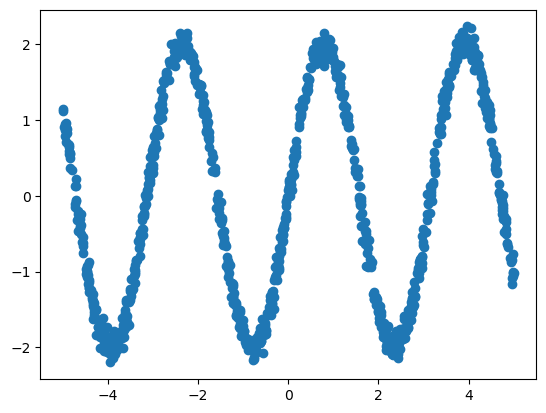

In [ ]:
N = 1000
X = distributions.Uniform(-5, 5).sample((N, ))
y = 2*torch.sin(2*X) + distributions.Normal(0.0, 0.1).sample((N,))
print(X.shape)
print(y.shape)
plt.scatter(X, y)


In [ ]:
# make prototype data of shape (D, N)
# D = number of genes
# N = number of spatial locations
D = 10
y_distribution = distributions.Poisson(torch.rand(D, N) * 10.0)
y = y_distribution.sample()
print(y.shape)

torch.Size([10, 1000])


In [ ]:
M = 100
kernel = NSF_RBF(sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, dim=1, M=M, jitter=1e-3)
gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
model = NSF(gp, y, M=M, L=2)

In [ ]:
model.to(device)

NSF(
  (gp): VNNGP(
    (kernel): NSF_RBF()
  )
)

In [ ]:
X_train = (X[:, None]).to(device)
y_train = y.to(device)

In [ ]:
def fit(model, X, y, optimizer, epochs=1000, E=20):
    losses = []
    for it in tqdm(range(epochs)):
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X, E=E, verbose=True)
        ELBO = (pY.log_prob(y)).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        loss = -ELBO
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print("finished Training")
    return losses

In [ ]:
model.gp.K = 5

In [ ]:
optimizer = optim.Adam(params= model.parameters(), lr=1e-2)

In [ ]:
losses = fit(model, X_train, y_train, optimizer, epochs=100, E=200)

  0%|          | 0/100 [00:00<?, ?it/s]

Kxx.shape before view  torch.Size([10, 1000])
calculating Kxx
Kxx.shape torch.Size([10000, 1])


TypeError: forward() got an unexpected keyword argument 'return_distance'

In [ ]:
#F shape  torch.Size([200, 1, 10000])
#W shape  torch.Size([100, 1])

## Visium Data Analysis

In [ ]:
%pwd

'/Users/priyankashrestha/Documents/stanford/research/engelhardt_research/GPzoo/notebooks'

In [ ]:
%cd ..

/Users/priyankashrestha/Documents/stanford/research


In [ ]:
%cd data

[Errno 2] No such file or directory: 'data'
/Users/priyankashrestha/Documents/stanford/research/engelhardt_research/data


NameError: name 'sc' is not defined